# Sentiment Prediction using Albanian Posts

This notebook will create a model to predict the sentiment of Albanian posts. The dataset used is taken from this paper: [Human-annotated dataset for social media sentiment analysis for Albanian language](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9272335/)

`Kadriu F, Murtezaj D, Gashi F, Ahmedi L, Kurti A, Kastrati Z. Human-annotated dataset for social media sentiment analysis for Albanian language. Data Brief. 2022 Jul 2;43:108436. doi: 10.1016/j.dib.2022.108436. PMID: 35832321; PMCID: PMC9272335.`

## Dataset

The contents of the dataset are as follows:
* Id
* Comment
* Like
* Comment's timestamp
* Post's timestamp
* #Deaths
* #Infected
* #Healed
* Annot 1
* Annot 2
* Annot 3
* Final annotation

The "Final annotation" column is the sentiment label of the comment. This column together with the "Comment" column will be used to train the model.

The dataset contains 10k comments with the following mapping of the sentiment labels:

0 - Neutral
1 - Positive
2 - Negative

This is an example taken from the paper:

| Comment | Sentiment |
| --- | --- |
| Do te thot Pejaa edhe sonte spaska asnje rast (It means that also tonight Peja does not have any new case) | Neutral (0) |
| Bravo ekipet e IKShP per punen e shkelqyeshme dhe perkushtimin! (Well done the NIPHK teams for the great job and dedication!) | Positive (1) |
| Keni kalu tash ne monotoni, te pa arsyshem jeni tash. (You have now turned into monotony, you are now unreasonable.) | Negative (2) |

## Approach

The approach taken to create the model is as follows:

1. Load the dataset 
2. Preprocess the data
3. Tokenize the data
4. Create the model
5. Train the model
6. Evaluate the model
7. Predict the sentiment of a new comment
8. Save the model


### Load the dataset

In [2]:
import pandas as pd

# Read the data from the CSV file
df = pd.read_csv('./data/alb-sentiment-dataset.csv', sep=';')

df.head()

,Id,Comment,Like,Comment's timestamp,Post's timestamp,#Deaths,#Infected,#Healed,Annot 1,Annot 2,Annot 3,Final annotation
0,1,Mbyllni kufijte sot. Sitiata ka me u ba shume ...,0,"Friday, March 13, 2020 1:05am GMT","Thursday, March 12, 2020 5:20pm GMT",0,0,0,2,2,0,2
1,2,"Mbyllni kufit ashtu mund te jemi te sigurte, p...",0,"Thursday, March 12, 2020 8:06pm GMT","Thursday, March 12, 2020 5:20pm GMT",0,0,0,0,2,0,0
2,3,"Pse nuk po i mbyllni kufijte, sonte ne q...",1,"Thursday, March 12, 2020 7:41pm GMT","Thursday, March 12, 2020 5:20pm GMT",0,0,0,0,0,0,0
3,4,Mos harroni qe kufinjte tane jane te ha...,1,"Thursday, March 12, 2020 7:39pm GMT","Thursday, March 12, 2020 5:20pm GMT",0,0,0,0,0,0,0
4,5,Flm per njoftimet e vazhdueshme. A i kontrolli...,0,"Thursday, March 12, 2020 6:14pm GMT","Thursday, March 12, 2020 5:20pm GMT",0,0,0,1,1,1,1


### Process the data

In [3]:
# Keep only the columns we need
if 'Comment' in df.columns and 'Final annotation' in df.columns:
	df = df[['Comment', 'Final annotation']]

	# Change the column names to 'text' and 'sentiment'
	df.columns = ['text', 'sentiment']

print(df.shape)
df.head()

(10132, 2)


,text,sentiment
0,Mbyllni kufijte sot. Sitiata ka me u ba shume ...,2
1,"Mbyllni kufit ashtu mund te jemi te sigurte, p...",0
2,"Pse nuk po i mbyllni kufijte, sonte ne q...",0
3,Mos harroni qe kufinjte tane jane te ha...,0
4,Flm per njoftimet e vazhdueshme. A i kontrolli...,1


In [4]:
# Check for missing values

df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [5]:
# Check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10132 entries, 0 to 10131
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       10132 non-null  object
 1   sentiment  10132 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.4+ KB


<Axes: xlabel='sentiment'>

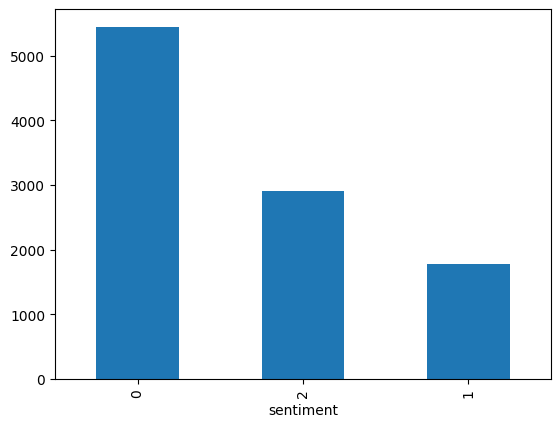

In [6]:
# Show frequency of each sentiment

df['sentiment'].value_counts().plot(kind='bar')

## Data Augmentation

In [7]:
import random
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        add_word(words)
    sentence = ' '.join(words)
    return sentence

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(words)-1)
    words.insert(random_idx, random_synonym)

def random_swap(sentence, n):
    words = sentence.split()
    for _ in range(n):
        words = swap_word(words)
    sentence = ' '.join(words)
    return sentence

def swap_word(words):
    idx1 = random.randint(0, len(words)-1)
    idx2 = idx1
    counter = 0
    while idx2 == idx1:
        idx2 = random.randint(0, len(words)-1)
        counter += 1
        if counter > 3:
            return words
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return words[rand_int]
    sentence = ' '.join(new_words)
    return sentence

def augment_text(sentence):
    augmentations = [
        synonym_replacement(sentence, n=2),
        random_insertion(sentence, n=2),
        random_swap(sentence, n=2),
        random_deletion(sentence, p=0.3),
    ]
    return random.choice(augmentations)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\denis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
import random

# Data augmentation on the dataset
df_neutral = df[df['sentiment'] == 0]
df_positive = df[df['sentiment'] == 1]
df_negative = df[df['sentiment'] == 2]

n_augmented_samples = 3000

# Generate augmented samples for the negative class
augmented_texts_negative = [augment_text(text) for text in random.choices(df_negative['text'].tolist(), k=n_augmented_samples)]
augmented_negative_df = pd.DataFrame({'text': augmented_texts_negative, 'sentiment': 1})

# Generate augmented samples for the positive class
augmented_texts_positive = [augment_text(text) for text in random.choices(df_positive['text'].tolist(), k=n_augmented_samples)]
augmented_positive_df = pd.DataFrame({'text': augmented_texts_positive, 'sentiment': 2})

# Append the augmented dataframes to the original dataframe
df_augmented = pd.concat([df, augmented_negative_df, augmented_positive_df], ignore_index=True)

<Axes: xlabel='sentiment'>

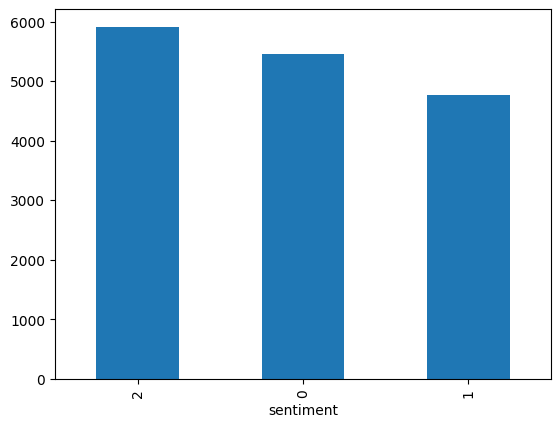

In [10]:
# Show changes in the frequency of each sentiment
df_augmented['sentiment'].value_counts().plot(kind='bar')

# A small difference in the number of samples for each class is acceptable

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=0)

In [16]:
stopwords_al = ["ë", "të", "i", "më", "që", "në", "një", "a", "për", "sh", "nga", "ka", "u", "është", "dhe", "shih", "nuk", "m", "diçka", "ose", "si", "shumë", "etj", "se", "pa", "sipas", "s", "t", "dikujt", "dikë", "mirë", "vet", "bëj", "ai", "vend", "prej", "ja", "duke", "tjetër", "kur", "ia", "ku", "ta", "keq", "dy", "bën", "bërë", "bëhet", "diçajë", "edhe", "madhë", "la", "sa", "gjatë", "zakonisht", "pas", "vetë", "mbi", "disa", "iu", "mos", "ç", "para", "dikush", "gjë", "bë", "pak", "tek", "farë", "bëri", "po", "bie", "k", "do", "gjithë", "vetë", "mund", "kam", "le", "jo", "bëje", "tij", "kanë", "ishte", "janë", "vjen", "atë", "këtë", "nëpër", "çdo", "na", "marrë", "merr", "mori", "rri", "deri", "b", "kishte", "mban", "përpara", "tyre", "marr", "gjitha", "as", "vetëm", "nën", "herë", "tjera", "tjerët", "drejt", "qenët", "ndonjë", "nëse", "jap", "merret", "rreth", "lloj", "dot", "saj", "nder", "ndërsa", "cila", "vetën", "ma", "ndaj", "mes", "ajo", "cilën", "por", "ndërmjet", "prapa", "mi", "tërë", "jam", "ashtu", "kësaj", "tillë", "behem", "cilat", "kjo", "menjëherë", "ça", "je", "aq", "aty", "pranë", "ato", "pasur", "qenë", "cilin", "tëper", "njëra", "tëj", "krejt", "kush", "bëjnë", "ti", "bënë", "midis", "cili", "endë", "këto", "kemi", "siç", "kryer", "cilit", "atij", "gjithnjë", "andej", "sipër", "sikur", "këtej", "cilës", "ky", "papritur", "ua", "kryesisht", "gjithçka", "pasi", "kryhet", "mjaft", "këtij", "përbashkët", "ata", "atje", "vazhdimisht", "kurrë", "tonë", "kështu", "unë", "sapo", "rrallë", "vetës", "ishin", "afërt", "tjetrën", "këtu", "çfarë", "to", "anës", "jemi", "asaj", "secila", "kundrejt", "këtyre", "pse", "tillë", "mua", "nëpërmjet", "cilet", "ndryshe", "kishin", "ju", "tani", "atyre", "diç", "ynë", "kudo", "sonë", "sepse", "cilave", "kem", "ty", "t'i", "nbsp", "tha", "re", "thë"]

In [17]:
import string

def process_text(text):
	text = text.lower()
	for punctuation in string.punctuation:
		text = text.replace(punctuation, '')
	text = text.strip()
	
	# Remove non-ASCII characters (such as emojis)
	text = text.encode('ascii', 'ignore').decode('ascii')
	text = ' '.join([word for word in text.split() if word not in stopwords_al])

	return text

X_train = X_train.apply(process_text)
X_test = X_test.apply(process_text)

In [19]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Convert to bag-of-words representation
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit_transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)

# Create folders if they don't exist
import os
os.makedirs('./models/sentiment', exist_ok=True)

# Save the CountVectorizer object
with open('./models/sentiment/count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vect, f)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(X_train_bag_of_words)
X_test_tf = tfidf_transformer.transform(X_test_bag_of_words)

# Save the TfidfTransformer object
with open('./models/sentiment/tfidf_transformer.pkl', 'wb') as f:
    pickle.dump(tfidf_transformer, f)

## Model Training

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Convert labels to a 1D array if they are not already
y_train_1d = np.array(y_train)

model = LogisticRegression()
parameters = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}]
grid_search = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=4,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train_tf, y_train_1d)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best accuracy:', best_accuracy)
print('Best parameters:', best_parameters)

# Save the model
with open('./models/sentiment/sentiment_model.pkl', 'wb') as f:
	pickle.dump(grid_search, f)

Best accuracy: 0.7068466375208136
Best parameters: {'C': 10}


c:\Users\denis\.virtualenvs\albanian-NLP-fTaZVMI_\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation

In [36]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

# Assuming y_test is already in the correct format (integer labels)
# If y_test is one-hot encoded, convert it back to integer labels
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = tf.argmax(y_test, axis=1).numpy()

# Make predictions
y_pred = grid_search.predict(X_test_tf)

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

# classification report
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

Accuracy:  0.7089294523926986
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76      1087
           1       0.80      0.64      0.71       358
           2       0.65      0.53      0.59       582

    accuracy                           0.71      2027
   macro avg       0.72      0.67      0.69      2027
weighted avg       0.71      0.71      0.70      2027



In [44]:
# Load the model
with open('./models/sentiment/sentiment_model.pkl', 'rb') as f:
	model = pickle.load(f)

# Load the CountVectorizer object
with open('./models/sentiment/count_vectorizer.pkl', 'rb') as f:
	count_vect = pickle.load(f)

# Load the TfidfTransformer object
with open('./models/sentiment/tfidf_transformer.pkl', 'rb') as f:
	tfidf_transformer = pickle.load(f)

# Process the input text
def process_input(text):
	text = process_text(text)
	text = count_vect.transform([text])
	text = tfidf_transformer.transform(text)
	return text

# Predict the sentiment of a new text
def predict_sentiment(text):
	text = process_input(text)
	prediction = model.predict(text)
	return prediction

# Test the model using a random text example from the test set with a positive, negative and neutral sentiment
positive_example = X_test[y_test == 1].iloc[random.randint(0, len(X_test[y_test == 1])-1)]
negative_example = X_test[y_test == 2].iloc[random.randint(0, len(X_test[y_test == 1])-1)]
neutral_example = X_test[y_test == 0].iloc[random.randint(0, len(X_test[y_test == 1])-1)]

print('Positive example:', positive_example)
print('Negative example:', negative_example)
print('Neutral example:', neutral_example)

positive_prediction = predict_sentiment(positive_example)
negative_prediction = predict_sentiment(negative_example)
neutral_prediction = predict_sentiment(neutral_example)

print('Positive prediction:', positive_prediction)
print('Negative prediction:', negative_prediction)
print('Neutral prediction:', neutral_prediction)

Positive example: bravo lumt dite nje lajm mir me me reste te reja e me shum te sheruar
Negative example: n prishtin n lagje jan infektuar myt me kto rrena dreqi hant
Neutral example: duhet lokacionet ne google map me jau qit qe me rujt tyne marre eshte qe jane infektu eshte koha per me mujt me ndale shperthimin spo di naj ekip per emergjence covid 19 qe hi formoj une me vullnetaret e rastit
Positive prediction: [1]
Negative prediction: [2]
Neutral prediction: [0]
